# Wine reviews analysis and prediction

In [474]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn 
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100) 

# EDA

In [475]:
df = pd.read_csv('winemag-data-130k-v2.csv')

In [476]:
df.shape

(129971, 14)

In [477]:
df.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [478]:
# Check amount of duplicates of 'title'
df.duplicated('title').sum()

11131

In [479]:
# Drop duplicates of 'title'
df = df.drop_duplicates(['title'], keep='first')

In [480]:
df.shape

(118840, 14)

After removing the title duplicates, 118,840 rows are left.

### Quick analysis 

In [481]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118840 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               118840 non-null int64
country                  118781 non-null object
description              118840 non-null object
designation              84551 non-null object
points                   118840 non-null int64
price                    110581 non-null float64
province                 118781 non-null object
region_1                 99346 non-null object
region_2                 46568 non-null object
taster_name              94107 non-null object
taster_twitter_handle    89587 non-null object
title                    118840 non-null object
variety                  118839 non-null object
winery                   118840 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.6+ MB


In the dataframe, there are 118,840 rows with 12 independent variables and one target variable: points.

In [482]:
df.describe()

,Unnamed: 0,points,price
count,118840.000000,118840.000000,110581.000000
mean,63044.561192,88.443748,35.587162
std,37521.108588,3.094261,41.895316
min,0.000000,80.000000,4.000000
25%,30283.750000,86.000000,17.000000
50%,62145.500000,88.000000,25.000000
75%,95235.250000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


As one can see from the description table, the point (target variable) are on average  88, on a scale from 0 to 100. It has to be noted that this dataset only contains wine reviews that are above 80 points.

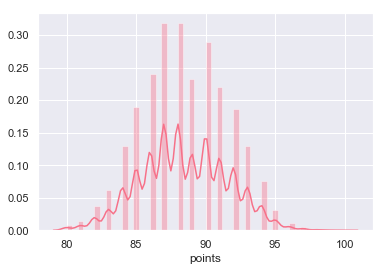

In [483]:
sns.distplot(df['points'])

The distribution of the points is normally distributed, therefore we can leave it as it is.

Since the column 'Unnamed: 0 ' is only an index counter, it does not add any value. Therefore the column is dropped. 

In [484]:
# Drop 'Unnamed: 0'
df.drop('Unnamed: 0', axis=1, inplace=True)

### Missing Values 

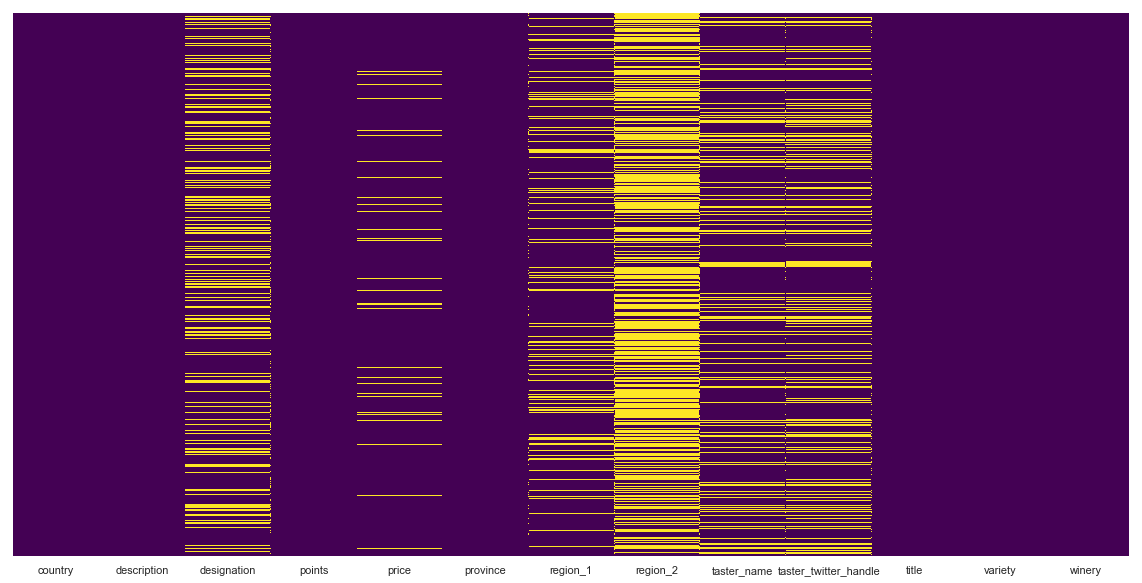

In [485]:
# Check for missing values
plt.figure(figsize=(20,10))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [486]:
# Count missing values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

country                     59
designation              34289
price                     8259
province                    59
region_1                 19494
region_2                 72272
taster_name              24733
taster_twitter_handle    29253
variety                      1
dtype: int64

In [487]:
# Percentage of missing values
(df[null_columns].isnull().sum() / 118840)*100

country                   0.049647
designation              28.853080
price                     6.949680
province                  0.049647
region_1                 16.403568
region_2                 60.814541
taster_name              20.812016
taster_twitter_handle    24.615449
variety                   0.000841
dtype: float64

As one can see, there are a lot of missing values for designation, region_2, taster_name and taster_twitter_handle.

Region_2 is a more specific regions specified within a wine growing area. Hence it is a specialization of region_1. Since 60% is region_2 is not filled in, we will drop this column in our first iteration.

In [488]:
# Drop columns with a lot of missing values: region_2
df.drop('region_2', axis=1, inplace=True)

Since taster_twitter_handle is only the Twitter name of the taster, it does not add any extra value to the taster's name. Therefore we will drop this column as well. 

In [489]:
# Drop columns with irrelevant information: 'taster_twitter_handle'
df.drop('taster_twitter_handle', axis=1, inplace=True)

----------------------------------------------------------

Since there are a lot of unique values for 'designation', we will create a top10 and classify everything outside that top10 as the value 'Other'.

In [490]:
# Check unique values for designation
df.designation.value_counts()

Reserve                                                        1869
Estate                                                         1218
Reserva                                                        1175
Riserva                                                         645
Estate Grown                                                    565
Brut                                                            385
Dry                                                             376
Barrel sample                                                   348
Estate Bottled                                                  318
Crianza                                                         311
Vieilles Vignes                                                 280
Barrel Sample                                                   247
Gran Reserva                                                    246
Tradition                                                       208
Old Vine                                        

In [491]:
# Top 10 most common Designations
df.designation.value_counts()[:10]

Reserve           1869
Estate            1218
Reserva           1175
Riserva            645
Estate Grown       565
Brut               385
Dry                376
Barrel sample      348
Estate Bottled     318
Crianza            311
Name: designation, dtype: int64

In [492]:
values_designation = df['designation'].value_counts()[:10].keys().tolist()
counts_designation = df['designation'].value_counts()[:10].tolist()

We will replace all values other than the top 10 with 'Other'.

In [493]:
# Function that returns the value 'Other' for every funder other than in the top_ten list
def designation_other(x):
    if x.designation in values_designation:
        return x.designation
    else:
        return 'Other'

In [494]:
# apply function to replace values with 'Other'
df.designation = df.apply(designation_other, axis=1)

-----------------------------------------------------------------------------

Now we are going to fill the missing values of 'price' with the median.

In [495]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr.fit(df['price'].values.reshape(-1, 1))
imputed_data = imr.transform(df['price'].values.reshape(-1, 1))
df['price'] = imputed_data

--------------------------

We will now create a top10 for 'region_1' and classify all values not in top10 as 'Other'.

In [496]:
# Check unique values for region_1
df.region_1.value_counts()

Napa Valley                              4160
Columbia Valley (WA)                     3780
Russian River Valley                     2854
California                               2413
Mendoza                                  2151
Paso Robles                              2138
Willamette Valley                        2110
Alsace                                   1960
Barolo                                   1492
Finger Lakes                             1445
Sonoma Coast                             1374
Rioja                                    1343
Brunello di Montalcino                   1335
Champagne                                1239
Sonoma County                            1147
Toscana                                  1115
Walla Walla Valley (WA)                   995
Chianti Classico                          964
Carneros                                  922
Yakima Valley                             917
Santa Barbara County                      914
Sta. Rita Hills                   

In [498]:
values_region1 = df['region_1'].value_counts()[:10].keys().tolist()
counts_region1 = df['region_1'].value_counts()[:10].tolist()

In [499]:
def region1_other(x):
    if x.region_1 in values_region1:
        return x.region_1
    else:
        return 'Other'

In [500]:
# apply function to replace values with 'Other'
df.region_1 = df.apply(region1_other, axis=1)

-------------------------------------------------------------

In [501]:
# Count missing values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

country           59
province          59
taster_name    24733
variety            1
dtype: int64

As we can see, there are still 59 rows with missing value of country. This amount can be neglected. Therefore we will simply drop these rows. We do this by overwriting the dataframe where country is not null.

In [502]:
df=df.loc[df.country.notnull()]

In [503]:
# Count missing values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

taster_name    24733
variety            1
dtype: int64

--------------------------------------------------------------------------

All missing values of 'taster_name' will be replaced with 'Unknown'.

In [504]:
df.taster_name.fillna(value='Unknown',inplace=True)

We will now create a top10 of variety and assign every value outside this top10 as 'Other'.

In [505]:
# Check unique values for variety
df.variety.value_counts()

Pinot Noir                    12191
Chardonnay                    10778
Cabernet Sauvignon             8822
Red Blend                      8210
Bordeaux-style Red Blend       6380
Riesling                       4758
Sauvignon Blanc                4542
Syrah                          3822
Rosé                           3214
Merlot                         2887
Nebbiolo                       2599
Zinfandel                      2524
Sangiovese                     2458
Malbec                         2446
Portuguese Red                 2269
White Blend                    2163
Sparkling Blend                1706
Tempranillo                    1666
Rhône-style Red Blend          1340
Pinot Gris                     1317
Cabernet Franc                 1241
Grüner Veltliner               1197
Champagne Blend                1092
Portuguese White               1055
Pinot Grigio                    978
Gewürztraminer                  936
Bordeaux-style White Blend      928
Gamay                       

In [506]:
values_variety = df['variety'].value_counts()[:10].keys().tolist()
counts_variety = df['variety'].value_counts()[:10].tolist()

In [507]:
def variety_other(x):
    if x.variety in values_variety:
        return x.variety
    else:
        return 'Other'

In [508]:
# apply function to replace values with 'Other'
df.variety = df.apply(variety_other, axis=1)

At last, we will create a top20 for the 'province' and classify all values.

In [509]:
# Check unique values for province
df.province.value_counts()

California                   33470
Washington                    7944
Bordeaux                      5400
Tuscany                       5384
Oregon                        4921
Burgundy                      3599
Northern Spain                3547
Piedmont                      3427
Mendoza Province              3037
New York                      2453
Veneto                        2423
Alsace                        2166
Northeastern Italy            1956
Loire Valley                  1650
Sicily & Sardinia             1631
Southwest France              1379
South Australia               1268
Southern Italy                1254
Champagne                     1239
Provence                      1194
Douro                         1175
Central Italy                 1132
Rhône Valley                   985
Catalonia                      978
Mosel                          944
Beaujolais                     939
Alentejano                     858
Colchagua Valley               779
Virginia            

In [510]:
values_province = df['province'].value_counts()[:20].keys().tolist()
counts_province = df['province'].value_counts()[:20].tolist()

In [511]:
def province_other(x):
    if x.province in values_province:
        return x.province
    else:
        return 'Other'

In [512]:
# apply function to replace values with 'Other'
df.province = df.apply(province_other, axis=1)

End of handling missing values.

### Dropping categorical columns with too many unique values

In [513]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Other,87,25.0,Sicily & Sardinia,Other,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),Other,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Other,87,15.0,Other,Other,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Other,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",Other,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Other,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Other,87,13.0,Other,Other,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Other,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [521]:
print('Country unique values: ' + str(df.country.nunique()))
print('Designation unique values: ' + str(df.designation.nunique()))
print('Province unique values: ' + str(df.province.nunique()))
print('Region1 unique values: ' + str(df.region_1.nunique()))
print('Taster unique values: ' + str(df.taster_name.nunique()))
print('Variety unique values: ' + str(df.variety.nunique()))
print('Winery unique values: ' + str(df.winery.nunique()))
print('Year review unique values: ' + str(df.year_review.nunique()))

Country unique values: 43
Designation unique values: 11
Province unique values: 21
Region1 unique values: 11
Taster unique values: 20
Variety unique values: 11


AttributeError: 'DataFrame' object has no attribute 'winery'

As we can see, there are too many distinct or unique values for Winery. Therefore, we will drop this column.

In [515]:
df.drop('winery', axis=1, inplace=True)

---------------------------------------------

## Feature extraction 

We will now extract extra information from certain columns. We will start by extracting the review year from the column 'title'.

In [516]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",Other,87,25.0,Sicily & Sardinia,Other,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),Other
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Other,87,15.0,Other,Other,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Other
2,US,"Tart and snappy, the flavors of lime flesh and...",Other,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Other
3,US,"Pineapple rind, lemon pith and orange blossom ...",Other,87,13.0,Other,Other,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
4,US,"Much like the regular bottling from 2012, this...",Other,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir


For example, in row 1, we will extract '2013' from the string 'Nicosia 2013 Vulkà Bianco (Etna)'.

In [517]:
# Create new empty column 'year_review'
df['year_review'] = ''

In [518]:
df.loc[df['title'].str.contains('2008'), 'year_review'] = '2008'
df.loc[df['title'].str.contains('2009'), 'year_review'] = '2009'
df.loc[df['title'].str.contains('2010'), 'year_review'] = '2010'
df.loc[df['title'].str.contains('2011'), 'year_review'] = '2011'
df.loc[df['title'].str.contains('2012'), 'year_review'] = '2012'
df.loc[df['title'].str.contains('2013'), 'year_review'] = '2013'
df.loc[df['title'].str.contains('2014'), 'year_review'] = '2014'
df.loc[df['title'].str.contains('2015'), 'year_review'] = '2015'

In [519]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,year_review
0,Italy,"Aromas include tropical fruit, broom, brimston...",Other,87,25.0,Sicily & Sardinia,Other,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),Other,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Other,87,15.0,Other,Other,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Other,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",Other,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Other,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Other,87,13.0,Other,Other,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,2013
4,US,"Much like the regular bottling from 2012, this...",Other,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,2012


In [522]:
# Check if every row of year_review is filled
df[df.year_review.isnull()]

,country,description,designation,points,price,province,region_1,taster_name,title,variety,year_review


### Bag-of-words  

Bag of words allows to represent text as numerical feature vectors. The idea is as follows:
1. Create a vocabulary of unique tokens (words in text)
2. Construct a feature vector from each row that contains the counts of how often each word occurs in that particular row

In [56]:
# Text analysis: make a series of most common words in 'description' and vectorize them. For example: row 1{'fruit': 0,'tropical':1}

First we will create a new feature: length of description. It could be an important indicator for the target variable 'points'.

In [523]:
df['length_description'] = df['description'].apply(len)

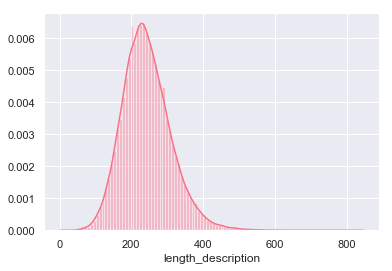

In [524]:
sns.distplot(df['length_description'],bins=100)

In [525]:
df['length_description'].describe()

count    118781.000000
mean        242.950043
std          67.179376
min          20.000000
25%         197.000000
50%         237.000000
75%         283.000000
max         829.000000
Name: length_description, dtype: float64

We will check in a visual way if the length has a relation with the points. Where we will plot certain point ranges and the length of the description.

In [526]:
# Rows with a high score, where the points are higher than 90
df[df['points'] > 90].shape

(31426, 12)

In [527]:
# Rows with a low score, where the points are higher than 80, but lower than 90
df[(df['points'] > 80) & (df['points'] < 90)].shape

(73199, 12)

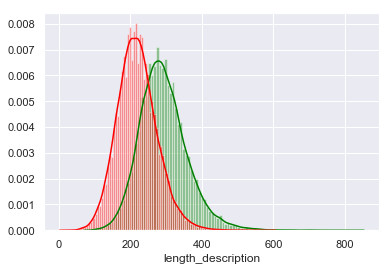

In [528]:
sns.distplot(df[df['points'] > 90]['length_description'],bins=100, color='green')
sns.distplot(df[(df['points'] > 80) & (df['points'] < 90)]['length_description'],bins=100, color='red')

We can see that the average length of description of wine review are higher for review higher than 90 points. Therefore, we will take this variable into account when constructing ML models.

------------------------------------------------------------

We will now drop all columns that are not needed anymore, such as 'description' and 'title'.

In [529]:
columns_todrop = ['description', 'title']
df.drop(columns_todrop, inplace=True, axis=1)

# Handling categorical data

In [530]:
df.head()

,country,designation,points,price,province,region_1,taster_name,variety,year_review,length_description
0,Italy,Other,87,25.0,Sicily & Sardinia,Other,Kerin O’Keefe,Other,2013,172
1,Portugal,Other,87,15.0,Other,Other,Roger Voss,Other,2011,227
2,US,Other,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Other,2013,186
3,US,Other,87,13.0,Other,Other,Alexander Peartree,Riesling,2013,199
4,US,Other,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,2012,249


In [531]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  3
Number of Categorical features:  7


In [532]:
for catg in list(categorical_feats) :
    print(df[catg].value_counts())
    print('-'*50)

US                        50229
France                    19739
Italy                     17805
Spain                      6021
Portugal                   5222
Chile                      4178
Argentina                  3543
Austria                    3022
Australia                  2183
Germany                    1990
South Africa               1301
New Zealand                1276
Israel                      466
Greece                      429
Canada                      226
Bulgaria                    132
Hungary                     129
Romania                     101
Uruguay                      98
Turkey                       80
Slovenia                     77
Georgia                      76
Croatia                      70
Mexico                       68
England                      63
Moldova                      56
Brazil                       49
Lebanon                      32
Morocco                      24
Peru                         16
Ukraine                      14
Czech Re

Before we create dummy variables for eacht categorical variable, we will first take a look how categorical values influence the target.

In [533]:
df.head(3)

,country,designation,points,price,province,region_1,taster_name,variety,year_review,length_description
0,Italy,Other,87,25.0,Sicily & Sardinia,Other,Kerin O’Keefe,Other,2013,172
1,Portugal,Other,87,15.0,Other,Other,Roger Voss,Other,2011,227
2,US,Other,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Other,2013,186


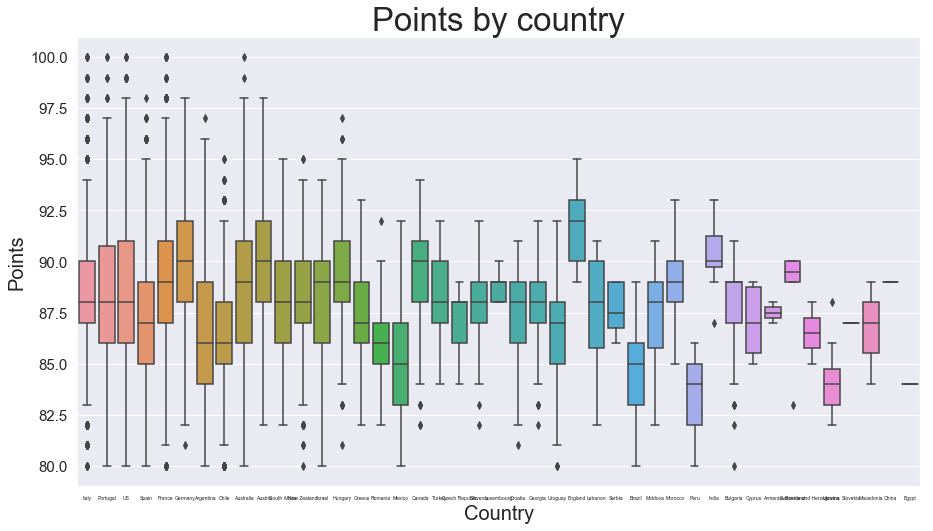

In [534]:
fig, ax = plt.subplots()
fig.set_size_inches(15.1, 8.27)
sns.set(style="darkgrid",palette="husl")
sns.boxplot(x=df.country,y=df.points,data=df)

plt.title('Points by country', fontsize=33)
plt.ylabel("Points", fontsize=20)
plt.xlabel("Country", fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=5)
plt.show()


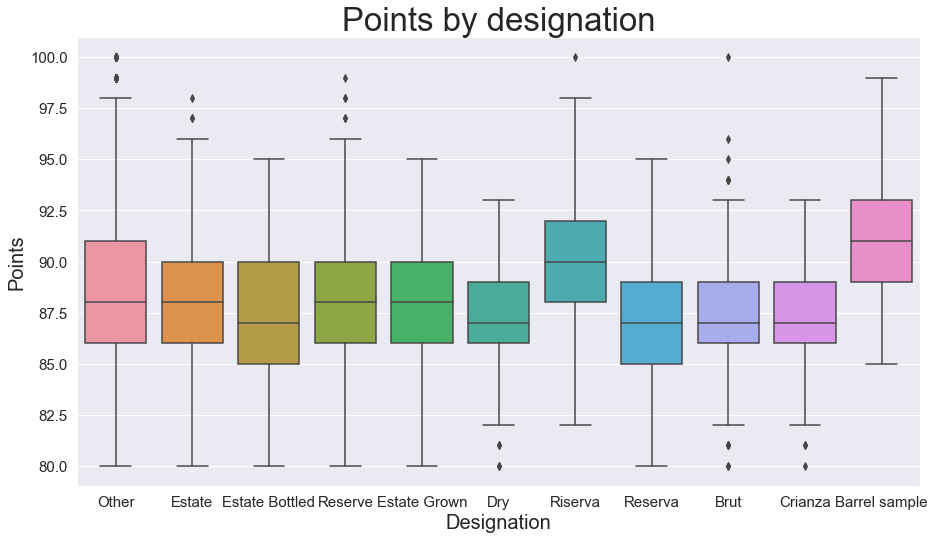

In [535]:
fig, ax = plt.subplots()
fig.set_size_inches(15.1, 8.27)
sns.set(style="darkgrid",palette="husl")
sns.boxplot(x=df.designation,y=df.points,data=df)

plt.title('Points by designation', fontsize=33)
plt.ylabel("Points", fontsize=20)
plt.xlabel("Designation", fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

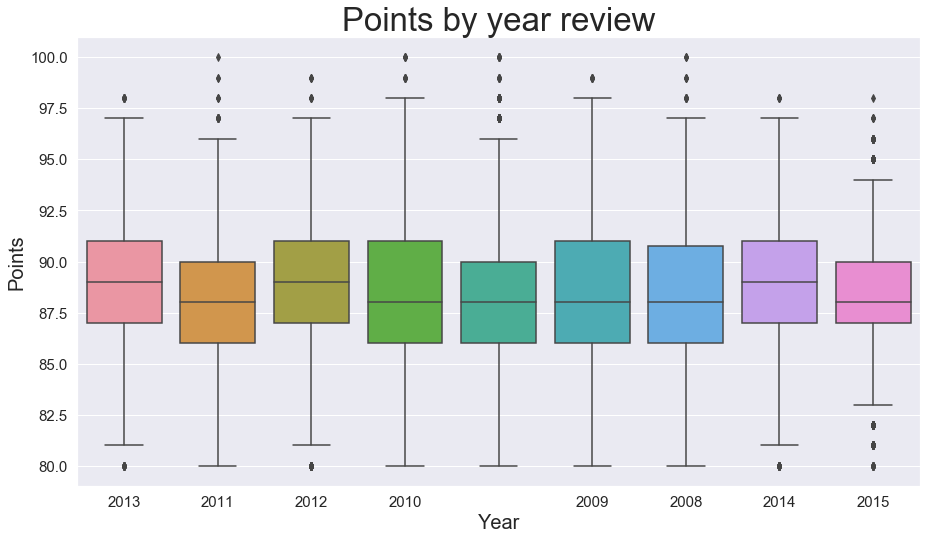

In [536]:
fig, ax = plt.subplots()
fig.set_size_inches(15.1, 8.27)
sns.set(style="darkgrid",palette="husl")
sns.boxplot(x=df.year_review,y=df.points,data=df)

plt.title('Points by year review', fontsize=33)
plt.ylabel("Points", fontsize=20)
plt.xlabel("Year", fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

We will create dummy variables for all the categorical variables.

In [537]:
df.head()

,country,designation,points,price,province,region_1,taster_name,variety,year_review,length_description
0,Italy,Other,87,25.0,Sicily & Sardinia,Other,Kerin O’Keefe,Other,2013,172
1,Portugal,Other,87,15.0,Other,Other,Roger Voss,Other,2011,227
2,US,Other,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Other,2013,186
3,US,Other,87,13.0,Other,Other,Alexander Peartree,Riesling,2013,199
4,US,Other,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,2012,249


In [538]:
df_dummies = pd.get_dummies(df[['country','designation','province','region_1','taster_name','variety','year_review']], drop_first = True)

In [539]:
# Merge the dummies dataframe with the original dataframe
df = pd.merge(df_dummies, df, left_index=True, right_index=True)

Now we have to drop the non-dummy columns.

In [540]:
df.drop(['country','designation','province','region_1','taster_name','variety','year_review'],axis=1, inplace=True)

# Standardize numerical variables 

Before we standardize the numerical variables, we will first check the distribution of them.

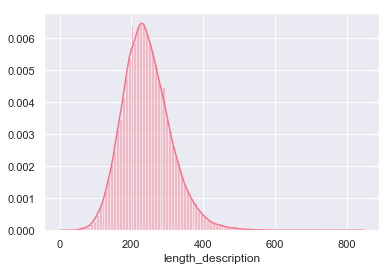

In [542]:
sns.distplot(df['length_description'],bins=100)

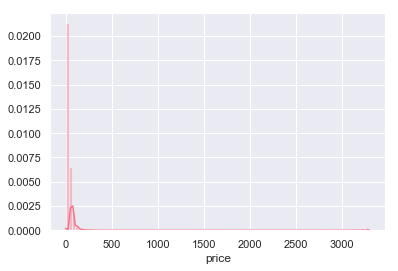

In [543]:
sns.distplot(df['price'],bins=100)

As we can see, the distribution of 'length_description' is normally distributed. However, 'price' has some heavy outliers. Therefore, we will first remove those outliers before scaling the variable.

In [545]:
df[df['price']>500].count()

country_Armenia                   87
country_Australia                 87
country_Austria                   87
country_Bosnia and Herzegovina    87
country_Brazil                    87
country_Bulgaria                  87
country_Canada                    87
country_Chile                     87
country_China                     87
country_Croatia                   87
country_Cyprus                    87
country_Czech Republic            87
country_Egypt                     87
country_England                   87
country_France                    87
country_Georgia                   87
country_Germany                   87
country_Greece                    87
country_Hungary                   87
country_India                     87
country_Israel                    87
country_Italy                     87
country_Lebanon                   87
country_Luxembourg                87
country_Macedonia                 87
country_Mexico                    87
country_Moldova                   87
c

Only 87 rows have a price higher than 500. Therefore we can remove those rows.

In [546]:
df = df.drop(df[df.price > 150].index)

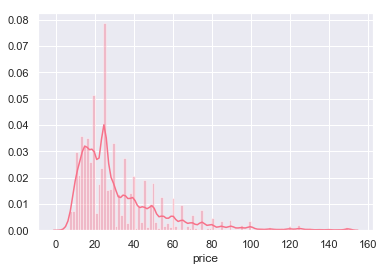

In [548]:
sns.distplot(df['price'],bins=100)

We can see that the distribution of the price is better now without the heavy outliers.

In [439]:
# Numerical features to standardize: price, length_description

In [549]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [550]:
scaled_features = scaler.fit_transform(df[['price', 'length_description']])
scaled_df = pd.DataFrame(scaled_features, columns=['price', 'length_description'])

In [551]:
# Merge scaled_df with normal df on index
df = pd.merge(scaled_df, df, left_index=True, right_index=True)

In [552]:
# Drop non-standardizes variables from the dataframe
columns = ['price_y', 'length_description_y']
df.drop(columns, inplace=True, axis=1)

# Data visualization

In [572]:
df.head()

,price_x,length_description_x,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Croatia,country_Cyprus,country_Czech Republic,country_Egypt,country_England,country_France,country_Georgia,country_Germany,country_Greece,country_Hungary,country_India,country_Israel,country_Italy,country_Lebanon,country_Luxembourg,country_Macedonia,country_Mexico,country_Moldova,country_Morocco,country_New Zealand,country_Peru,country_Portugal,country_Romania,country_Serbia,country_Slovakia,country_Slovenia,country_South Africa,country_Spain,country_Switzerland,country_Turkey,country_US,country_Ukraine,country_Uruguay,designation_Brut,designation_Crianza,designation_Dry,designation_Estate,designation_Estate Bottled,designation_Estate Grown,...,province_Veneto,province_Washington,region_1_Barolo,region_1_California,region_1_Columbia Valley (WA),region_1_Finger Lakes,region_1_Mendoza,region_1_Napa Valley,region_1_Other,region_1_Paso Robles,region_1_Russian River Valley,region_1_Willamette Valley,taster_name_Anna Lee C. Iijima,taster_name_Anne Krebiehl MW,taster_name_Carrie Dykes,taster_name_Christina Pickard,taster_name_Fiona Adams,taster_name_Jeff Jenssen,taster_name_Jim Gordon,taster_name_Joe Czerwinski,taster_name_Kerin O’Keefe,taster_name_Lauren Buzzeo,taster_name_Matt Kettmann,taster_name_Michael Schachner,taster_name_Mike DeSimone,taster_name_Paul Gregutt,taster_name_Roger Voss,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Unknown,taster_name_Virginie Boone,variety_Cabernet Sauvignon,variety_Chardonnay,variety_Merlot,variety_Other,variety_Pinot Noir,variety_Red Blend,variety_Riesling,variety_Rosé,variety_Sauvignon Blanc,variety_Syrah,year_review_2008,year_review_2009,year_review_2010,year_review_2011,year_review_2012,year_review_2013,year_review_2014,year_review_2015,points
0,-0.328446,-1.053357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,87
1,-0.777423,-0.228975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,87
2,-0.822321,-0.843514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,87
3,-0.867219,-0.648660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,87
4,1.467461,0.100778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,87


In [570]:
# Relationship between price and points

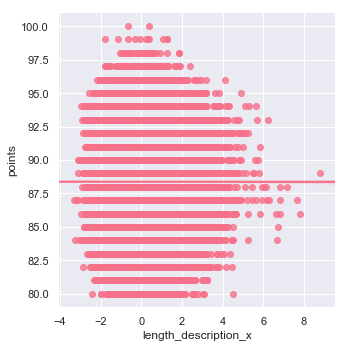

In [574]:
sns.lmplot(x="length_description_x", y="points", data=df);

# Learning and evaluation

In [553]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [554]:
df.shape

(107356, 122)

In [555]:
df.head()

,price_x,length_description_x,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Croatia,country_Cyprus,country_Czech Republic,country_Egypt,country_England,country_France,country_Georgia,country_Germany,country_Greece,country_Hungary,country_India,country_Israel,country_Italy,country_Lebanon,country_Luxembourg,country_Macedonia,country_Mexico,country_Moldova,country_Morocco,country_New Zealand,country_Peru,country_Portugal,country_Romania,country_Serbia,country_Slovakia,country_Slovenia,country_South Africa,country_Spain,country_Switzerland,country_Turkey,country_US,country_Ukraine,country_Uruguay,designation_Brut,designation_Crianza,designation_Dry,designation_Estate,designation_Estate Bottled,designation_Estate Grown,...,province_Veneto,province_Washington,region_1_Barolo,region_1_California,region_1_Columbia Valley (WA),region_1_Finger Lakes,region_1_Mendoza,region_1_Napa Valley,region_1_Other,region_1_Paso Robles,region_1_Russian River Valley,region_1_Willamette Valley,taster_name_Anna Lee C. Iijima,taster_name_Anne Krebiehl MW,taster_name_Carrie Dykes,taster_name_Christina Pickard,taster_name_Fiona Adams,taster_name_Jeff Jenssen,taster_name_Jim Gordon,taster_name_Joe Czerwinski,taster_name_Kerin O’Keefe,taster_name_Lauren Buzzeo,taster_name_Matt Kettmann,taster_name_Michael Schachner,taster_name_Mike DeSimone,taster_name_Paul Gregutt,taster_name_Roger Voss,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Unknown,taster_name_Virginie Boone,variety_Cabernet Sauvignon,variety_Chardonnay,variety_Merlot,variety_Other,variety_Pinot Noir,variety_Red Blend,variety_Riesling,variety_Rosé,variety_Sauvignon Blanc,variety_Syrah,year_review_2008,year_review_2009,year_review_2010,year_review_2011,year_review_2012,year_review_2013,year_review_2014,year_review_2015,points
0,-0.328446,-1.053357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,87
1,-0.777423,-0.228975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,87
2,-0.822321,-0.843514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,87
3,-0.867219,-0.648660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,87
4,1.467461,0.100778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,87


## Split training-test data 

In [556]:
X = df.drop('points', axis=1)
y = df['points']

In [557]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

## Testing different regressor algorithms 

Regressor algorithms to test:

1. LinearRegression

2. Ridge

3. DecisionTreeRegressor

4. RandomForestRegressor

5. AdaBoost Regressor 

6. XGBoost

### 1. Linear Regression

In [558]:
from sklearn.linear_model import LinearRegression

In [559]:
lr = LinearRegression()

In [560]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [561]:
lr_predictions = lr.predict(X_test)

In [562]:
# Evaluate model
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error

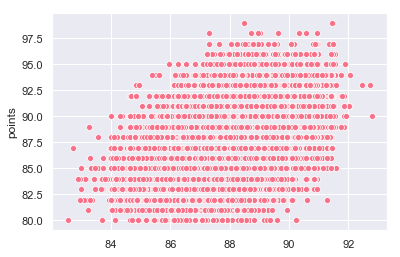

In [563]:
sns.scatterplot(lr_predictions,y_test)

In [564]:
MAE_lr = mean_absolute_error(y_test, lr_predictions)
MSE_lr = mean_squared_error(y_test, lr_predictions)
var_lr = explained_variance_score(y_test, lr_predictions)

In [565]:
print("MAE :" + str(MAE_lr))
print("MSE :" + str(MSE_lr))
print("Explained variance :" + str(var_lr))

MAE :2.2351985542766553
MSE :7.620577070399357
Explained variance :0.17543793458320178


### 2. Ridge Regression 

In [575]:
from sklearn.linear_model import Ridge

In [576]:
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=10, verbose=1, scoring = 'explained_variance')
grid_ridge.fit(X_train, y_train)

print(grid_ridge.best_score_)
print(grid_ridge.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
0.17669042154927084
{'alpha': 0.5, 'normalize': False, 'tol': 1e-06}


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  2.6min finished


In [ ]:
best_ridge = grid_ridge.best_params_

### 6. XGBoost 

In [566]:
import xgboost

In [567]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [568]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [569]:
predictions_xgb = xgb.predict(X_test)
print(explained_variance_score(predictions_xgb,y_test))

-3.651354989571245
